In [1]:
# Copyright(C) [2025] Advanced Micro Devices, Inc. All rights reserved.


# 🚀 GEAK-Agent Tutorial
### Generating Optimized GPU Kernels with LLM Agents

---

This notebook demonstrates **GEAK-Agent** - a multi-agent LLM framework that automatically generates and optimizes [Triton](https://github.com/openai/triton) GPU kernels.

| Step | What Happens |
|:----:|-------------|
| 1️⃣ | **Setup** - Configure API keys |
| 2️⃣ | **Initialize** - Load kernels and create agent |
| 3️⃣ | **Run** - Generate and optimize kernels |
| 4️⃣ | **Results** - View generated code and metrics |

---
## 1️⃣ Setup

In [2]:
""" Please do this for setup
git clone https://github.com/AMD-AGI/GEAK-agent.git
cd GEAK-agent
python3 -m pip install -r requirements.txt
"""

' Please do this for setup\ngit clone https://github.com/AMD-AGI/GEAK-agent.git\ncd GEAK-agent\npython3 -m pip install -r requirements.txt\n'

In [3]:
# Initialize environment
import os, sys

# Auto-detect paths
TUTORIAL_DIR = os.getcwd() if os.getcwd().endswith('tutorial') else os.path.join(os.getcwd(), 'tutorial')
GEAK_DIR = os.path.dirname(TUTORIAL_DIR)
SRC_DIR = os.path.join(GEAK_DIR, 'src')

# Add src first (so src/utils doesn't get shadowed)
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
if TUTORIAL_DIR not in sys.path:
    sys.path.insert(0, TUTORIAL_DIR)

# Import tutorial utilities
from tutorial_utils import setup_environment, print_header
TUTORIAL_DIR, SRC_DIR, CORPUS_PATH, TutorialDataloader = setup_environment()
print_header('✓ GEAK-Agent Tutorial Ready')

╔════════════════════════════════════════════════════════════╗
║ ✓ GEAK-Agent Tutorial Ready                                ║
╚════════════════════════════════════════════════════════════╝


In [4]:
# ═══════════════════════════════════════════════════════════════
#                       🔑 API CONFIGURATION
# ═══════════════════════════════════════════════════════════════

USE_AMD_API = True                              # Set False for OpenAI
AMD_API_KEY = os.getenv('AMD_API_KEY')          # Get from environment
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')    # Get from environment

# ───────────────────────────────────────────────────────────────
API_KEY = AMD_API_KEY if USE_AMD_API else OPENAI_API_KEY
MODEL_ID = 'gpt-5.2' if USE_AMD_API else 'claude-sonnet-4'
print(f'✓ API: {"AMD" if USE_AMD_API else "OpenAI"} | Model: {MODEL_ID}')

✓ API: AMD | Model: gpt-5.2


---
## 2️⃣ Initialize Dataset & Agent

In [5]:
from models.Claude import ClaudeModel
from models.Gemini import GeminiModel
from models.OpenAI import OpenAIModel
from agents.GaAgent import GaAgent

# Load kernels
dataset = TutorialDataloader(
    kernel_names=['embedding_triton_kernel.py'],
    corpus_path=CORPUS_PATH
)

# Initialize model & agent
# model = GeminiModel(api_key=API_KEY, model_id=MODEL_ID)
# model = ClaudeModel(api_key=API_KEY, model_id=MODEL_ID)
model = OpenAIModel(api_key=API_KEY, model_id=MODEL_ID)

agent = GaAgent(model=model, dataset=dataset, corpus_path=CORPUS_PATH, descendant_num=3)

print(f'✓ Loaded {len(dataset)} kernels | Agent ready with {len(agent.memories)} tasks')

✓ Loaded 1 kernels | Agent ready with 1 tasks


In [6]:
# Preview kernel instructions (optional)
from tutorial_utils import display_kernel_info
display_kernel_info(dataset.problem_states)


┌──────────────────────────────────────────────────────────────────────┐
│ 📄 embedding_triton_kernel.py                                       │
├──────────────────────────────────────────────────────────────────────┤
│ You are a expert in writing Triton operators for efficient GPU progr │
│ amming. Use triton language write a kernel and wrapper according fol │
│ lowing instruction.             The Triton-accelerated function embe │
│ dding_kernel is specialized for extracting and storing embedding vec │
│ tors from a weight matrix for a sequence of token IDs. It uses progr │
│ am IDs to determine processing offsets and handles iteration         │
│ ...[truncated]                                                       │
├──────────────────────────────────────────────────────────────────────┤
│ ✓ Has reference code: True                                          │
│ ✓ Has test code: True                                               │
└─────────────────────────────────────────────────────

---
## 3️⃣ Run GEAK-Agent

Each iteration: **Generate** → **Test** → **Benchmark** → **Reflect**

> ⏱️ Takes a few minutes per iteration

In [7]:
from tutorial_utils import print_config

OUTPUT_DIR = os.path.join(TUTORIAL_DIR, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ═══════════════════════════════════════════════════════════════
#                       ⚙️ CONFIGURATION
# ═══════════════════════════════════════════════════════════════
CONFIG = {
    'iteration_num': 3,       # Optimization iterations
    'temperature': 1.0,       # LLM creativity (0.0-2.0)
    'descendant_num': 3,      # Candidates per iteration
    'ancestor_num': 5,        # Reference solutions
    'gpu_id': 0,              # GPU device
    'target_gpu': 'MI325X',   # Target AMD GPU
}
print_config(CONFIG, '🚀 Running GEAK-Agent')


════════════════════════════════════════════════════════════
 🚀 Running GEAK-Agent
════════════════════════════════════════════════════════════
  • iteration_num: 3
  • temperature: 1.0
  • descendant_num: 3
  • ancestor_num: 5
  • gpu_id: 0
  • target_gpu: MI325X
════════════════════════════════════════════════════════════


In [ ]:
# Run the agent
!rm -rf {OUTPUT_DIR}  # Clean previous outputs
agent.run(
    output_path=os.path.join(OUTPUT_DIR, 'tutorial_results.jsonl'),
    multi_thread=False,
    **CONFIG,
    start_iter=0, descendant_debug=0, profiling=False, start_idx=0
)
print('\n✅ Complete!')

2026-01-08 01:09:40.010 | INFO     | agents.GaAgent:run:143 - 
=== Iteration 0 ===
2026-01-08 01:09:40.011 | INFO     | agents.GaAgent:run:152 - 
generate solution
  0%|          | 0/1 [00:00<?, ?it/s]

---
## 4️⃣ View Results

In [ ]:
from tutorial_utils import load_results, display_results_summary, display_generated_code

results, iteration = load_results(OUTPUT_DIR)
display_results_summary(results, iteration)


╔══════════════════════════════════════════════════════════════════════╗
║ 📊 GEAK-Agent Results Summary                                         ║
║ Iteration: 5                                                         ║
╠══════════════════════════════════════════════════════════════════════╣
║ Kernel              │ Call │ Exec │ Perf │ Speedup                   ║
╠──────────────────────────────────────────────────────────────────────╣
║ embedding_triton_k │  ✗   │  ✓   │  ✗   │ 4.3293x                    ║
╚══════════════════════════════════════════════════════════════════════╝

 Legend: ✓ = Passed, ✗ = Failed
 Speedup: reference_time / generated_time (>1.0 = faster)


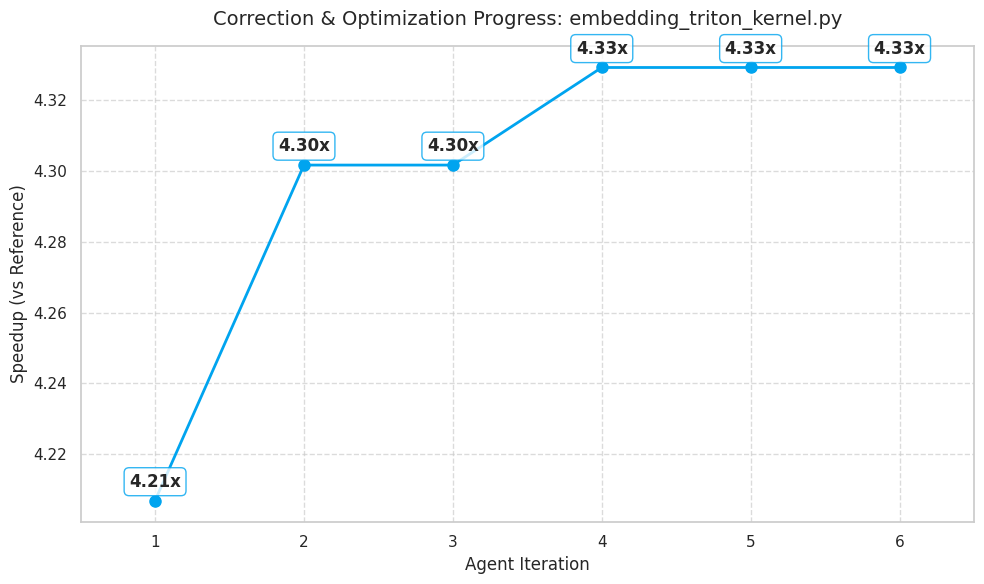

In [ ]:
from tutorial_utils import plot_speedup_curve_all_iterations
# Run with the output directory we defined earlier
plot_speedup_curve_all_iterations(OUTPUT_DIR)